In [ ]:
%matplotlib inline


# Permutation Importance with Multicollinear or Correlated Features


In this example, we compute the permutation importance on the Wisconsin
breast cancer dataset using :func:`~sklearn.inspection.permutation_importance`.
The :class:`~sklearn.ensemble.RandomForestClassifier` can easily get about 97%
accuracy on a test dataset. Because this dataset contains multicollinear
features, the permutation importance will show that none of the features are
important. One approach to handling multicollinearity is by performing
hierarchical clustering on the features' Spearman rank-order correlations,
picking a threshold, and keeping a single feature from each cluster.

<div class="alert alert-info"><h4>Note</h4><p>See also
    `sphx_glr_auto_examples_inspection_plot_permutation_importance.py`</p></div>


In [ ]:
print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import pandas as pd
plt.style.use('ggplot')

Automatically created module for IPython interactive environment


Random Forest Feature Importance on Breast Cancer Data
------------------------------------------------------
First, we train a random forest on the breast cancer dataset and evaluate
its accuracy on a test set:



In [ ]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state=42)

In [ ]:
# Visualize Dataset 
feature_names = data.feature_names
df = pd.DataFrame(X, columns=feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
diagnosis = pd.DataFrame(data.target, columns=['diagnosis'])
benign = diagnosis.value_counts()[1]
malign = diagnosis.value_counts()[0]
print ("Total number of diagnosis are", str(y.shape[0]), ",", 
       benign.values[0], "Benign and Malignant are",malign.values[0])

Total number of diagnosis are 569 , 357 Benign and Malignant are 212


Next, we plot the tree based feature importance and the permutation
importance. The permutation importance plot shows that permuting a feature
drops the accuracy by at most `0.012`, which would suggest that none of the
features are important. This is in contradiction with the high test accuracy
computed above: some feature must be important. The permutation importance
is calculated on the training set to show how much the model relies on each
feature during training.



In [ ]:
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.96


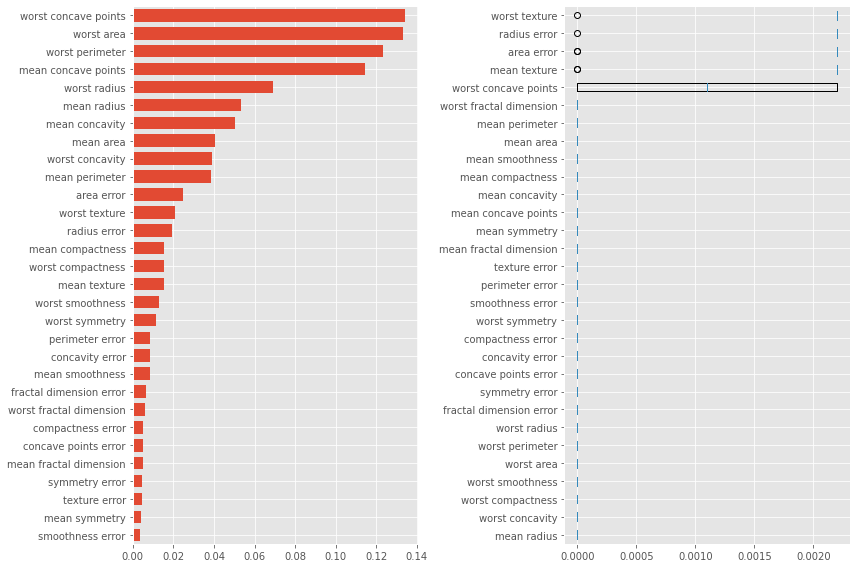

In [ ]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

Handling Multicollinear Features
--------------------------------
When features are collinear, permutating one feature will have little
effect on the models performance because it can get the same information
from a correlated feature. One way to handle multicollinear features is by
performing hierarchical clustering on the Spearman rank-order correlations,
picking a threshold, and keeping a single feature from each cluster. First,
we plot a heatmap of the correlated features:



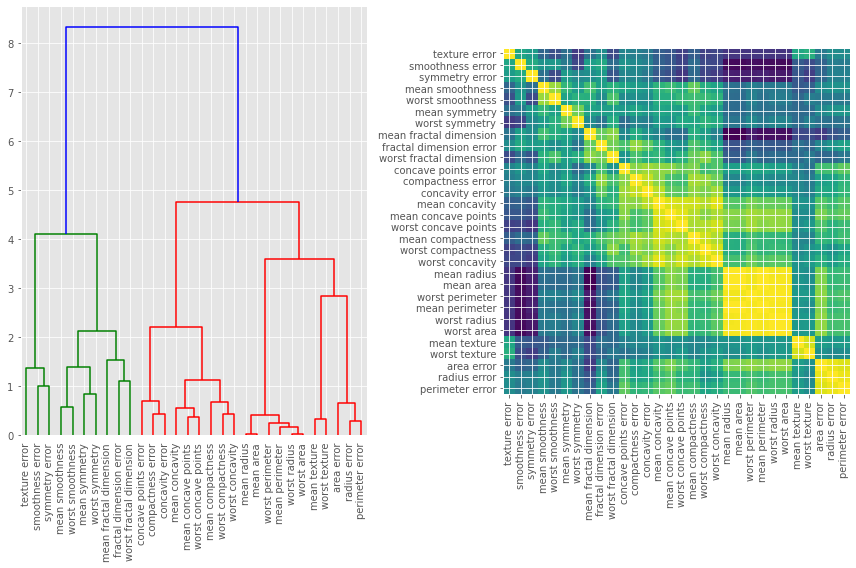

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

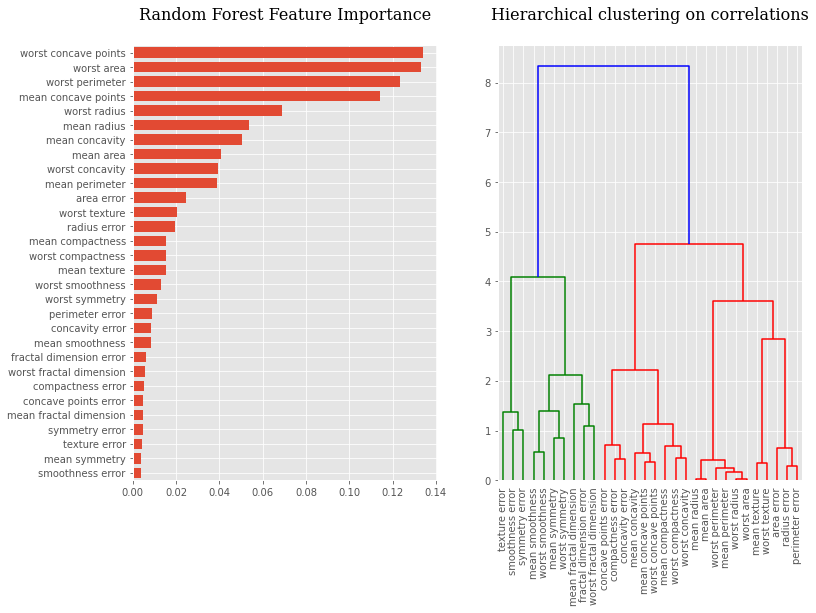

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title("Random Forest Feature Importance\n", fontdict=font)
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
#plt.title("Permutation Importance with Correlated Features\n", fontdict=font)
#  hierarchical clustering on the Spearman rank-order correlations
ax2.set_title("Hierarchical clustering on correlations\n", fontdict=font)
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=data.feature_names.tolist(), 
                              ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
#fig.tight_layout()
plt.show()

Next, we manually pick a threshold by visual inspection of the dendrogram
to group our features into clusters and choose a feature from each cluster to
keep, select those features from our dataset, and train a new random forest.
The test accuracy of the new random forest did not change much compared to
the random forest trained on the complete dataset.



In [ ]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=300, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.96


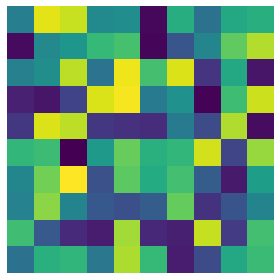

In [ ]:
plt.figure(figsize=(4,4));
plt.imshow(np.random.rand(10,10), interpolation='none');
plt.axis('off');
plt.tight_layout();

FROM: https://towardsdatascience.com/how-to-use-scikit-learn-datasets-for-machine-learning-d6493b38eca3

* **data** is all the feature data (the attributes of the scan that help us identify if the tumor is malignant or benign, such as radius, area, etc.) in a NumPy array

* **target** is the target data (the variable you want to predict, in this case whether the tumor is malignant or benign) in a NumPy array

In [ ]:
#Classifier implementing the k-nearest neighbors vote
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
logreg = KNeighborsClassifier(n_neighbors=6)
logreg.fit(X_train, y_train)
print("Accuracy on test data with  k-nearest neighbors vote : {:.2f}".format(
    logreg.score(X_test, y_test)))

Accuracy on test data with  k-nearest neighbors vote : 0.96


###  Deep Learning Model
Benign or Malignant classification problem, this deep learning model inherits the merits of the methods experimented by Stahl and Geekette

<br>
<br>
<a href="https://towardsdatascience.com/deep-learning-in-winonsin-breast-cancer-diagnosis-6bab13838abd"> 
<img src="https://miro.medium.com/max/700/1*xIvOCAVavJz7ZXCTGPsuOw.png" alt="batch Normalization" width=70% height=auto>
</a>
<br>
<br>
Figure 1: The Architecture of a the Deep Learning Model](https://towardsdatascience.com/deep-learning-in-winonsin-breast-cancer-diagnosis-6bab13838abd)



In [ ]:
# mlp with unscaled data for the regression problem
from sklearn.datasets import make_regression
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dropout 
from matplotlib import pyplot

In [ ]:
def createModel():
  model = Sequential()
  model.add(Dense(9, activation='relu', input_dim=30))   
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='relu', input_shape=(9,)))   
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid', input_shape=(5,)))
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
  return model
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 279       
_________________________________________________________________
dropout (Dropout)            (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.33, epochs=800, batch_size=10)

Epoch 1/500
31/31 [==============================] - 0s 8ms/step - loss: 77.1508 - accuracy: 0.5164 - val_loss: 76.5772 - val_accuracy: 0.5762
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 53.2317 - accuracy: 0.5789 - val_loss: 53.7370 - val_accuracy: 0.5762
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 38.7135 - accuracy: 0.5296 - val_loss: 36.0296 - val_accuracy: 0.5762
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 23.0526 - accuracy: 0.5493 - val_loss: 22.2721 - val_accuracy: 0.5762
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 16.6422 - accuracy: 0.4836 - val_loss: 10.3064 - val_accuracy: 0.5298
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 7.0374 - accuracy: 0.4441 - val_loss: 4.0997 - val_accuracy: 0.4834
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 3.0540 - accuracy: 0.3816 - val_loss: 1.4890 - val_accuracy: 0.3311
Epo

In [ ]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse[1], test_mse[1]))

Train: 0.629, Test: 0.623


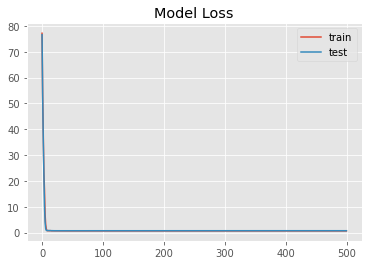

In [ ]:
# plot loss during training
pyplot.title('Model Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

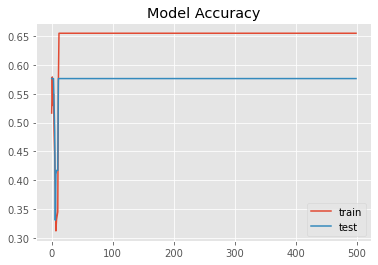

In [ ]:
# plot loss during training
pyplot.title('Model Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
#!pip install ceml
from ceml.tfkeras import generate_counterfactual
from ceml.backend.tensorflow.costfunctions import NegLogLikelihoodCost
from ceml.model import ModelWithLoss
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import tensorflow as tf

In [ ]:
# Select a data point whose prediction has to be explained
x_orig = X_test[1,:]
print("Prediction on x: {0}".format(model.predict(np.array([x_orig]))))

Prediction on x: [[0.65424633]]


In [ ]:


# Compute counterfactual
# Whitelist of features we can use/change when computing the counterfactual
features_whitelist = None

# Compute counterfactual
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1.0)    # Init optimization algorithm
optimizer_args = {"max_iter": 1000}

print("\nCompute counterfactual ....") 
print(generate_counterfactual(model, x_orig, y_target=0, 
                              features_whitelist=features_whitelist, 
                              regularization="l1", C=0.01, optimizer=optimizer, 
                              optimizer_args=optimizer_args))



Compute counterfactual ....


TypeError: ignored

### Test of Robustness:
10-fold cross validation is performed as follows to verify the robustness of the new deep learning model.

In [ ]:
patient = 9
sample = X_test[patient:patient+1,:]
diagnostic = y_test[patient]
if diagnostic == 0:
  print("Malignant")
else:
  print("Benigne")

Benigne


In [ ]:
# Select data point for explaining its prediction
print("Prediction on sample: {:.3f}".format(model.predict(sample)[0][0]*100))

Prediction on sample: 65.425


In [ ]:
from sklearn.model_selection import StratifiedKFold 

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=seed) 
cvscores = []
for train, test in kfold.split(X, y):
    model = createModel()
    model.fit(X[train], y[train], epochs=500, batch_size=10, 
              verbose=0)
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("{}: {}".format(model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("{} (+/- {})".format(np.mean(cvscores), np.std(cvscores)))

### Scaling Input Variables

"*If the input variables are combined linearly, as in an MLP [Multilayer Perceptron], then it is rarely strictly necessary to standardize the inputs, at least in theory. […] However, there are a variety of practical reasons why standardizing the inputs can make training faster and reduce the chances of getting stuck in local optima.*"

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import urllib.request
import pandas as pd
from collections import Counter
import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf

# Examine software versions
print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

In [ ]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=COLUMNS,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")
test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=COLUMNS,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?")

# Drop rows with missing values
train_df = train_df.dropna(how="any", axis=0)
test_df = test_df.dropna(how="any", axis=0)

print('UCI Adult Census Income dataset loaded.')

In [ ]:
# These are the features in the dataset.
# Dataset information: https://archive.ics.uci.edu/ml/datasets/census+income
_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

_CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'education': pd.api.types.CategoricalDtype(categories=[
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', '7th-8th', 'Doctorate', 'Assoc-voc', 'Prof-school',
       '5th-6th', '10th', 'Preschool', '12th', '1st-4th'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'gender': pd.api.types.CategoricalDtype(categories=[
        'Male', 'Female'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
}

# This is the label (target) we want to predict.
_LABEL_COLUMN = 'income_bracket'

In [ ]:
#Remove "." from 'income_bracket' column.
test_df['income_bracket'] = test_df['income_bracket'].apply(lambda x: x.replace('.', ''))

def preprocess(dataframe):
    """Converts categorical features to numeric. Removes unused columns.
  
    Args:
      dataframe: Pandas dataframe with raw data
  
    Returns:
      Dataframe with preprocessed data
    """
    #dataframe = dataframe.drop(columns=UNUSED_COLUMNS)

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Convert categorical columns to numeric
    cat_columns = dataframe.select_dtypes(['object']).columns
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(
        _CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe



In [ ]:
# Preprocess datasets (train and test)
prepped_train_df = preprocess(train_df)
prepped_eval_df = preprocess(test_df)

# Split train and test data with labels.
# The pop() method will extract (copy) and remove the label column from the dataframe
train_x, train_y = prepped_train_df, prepped_train_df.pop(_LABEL_COLUMN)
eval_x, eval_y = prepped_eval_df, prepped_eval_df.pop(_LABEL_COLUMN)

# Reshape label columns for use with tf.data.Dataset
train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))
test_y = np.asarray(eval_y).astype('float32').reshape((-1, 1))

In [ ]:
def standardize(dataframe):
    """Scales numerical columns using their means and standard deviation to get
    z-scores: the mean of each numerical column becomes 0, and the standard
    deviation becomes 1. This can help the model converge during training.
  
    Args:
      dataframe: Pandas dataframe
  
    Returns:
      Input dataframe with the numerical columns scaled to z-scores
    """
    dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float32':
            dataframe[column] -= dataframe[column].mean()
            dataframe[column] /= dataframe[column].std()
    return dataframe

In [ ]:
# Join train_x and eval_x to normalize on overall means and standard
# deviations. Then separate them again.
all_x = pd.concat([train_x, eval_x], keys=['train', 'eval'])
all_x = standardize(all_x)
train_X, test_X = all_x.xs('train'), all_x.xs('eval')

In [ ]:
# Verify dataset features
# Note how only the numeric fields (not categorical) have been standardized
train_X.head()

In [ ]:
clf_adult = RandomForestClassifier(n_estimators=300, random_state=42)
clf_adult.fit(train_X, train_y)
print("Accuracy on test data: {:.2f}".format(clf_adult.score(test_X, test_y)))

In [ ]:
result = permutation_importance(clf_adult, train_X, train_y, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_adult.feature_importances_)
tree_indices = np.arange(0, len(clf_adult.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf_adult.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(train_x.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf_adult.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=train_X.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(train_X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=train_X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title("Random Forest Feature Importance\n", fontdict=font)
ax1.barh(tree_indices,
         clf_adult.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(train_X.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf_adult.feature_importances_)))
#plt.title("Permutation Importance with Correlated Features\n", fontdict=font)
#  hierarchical clustering on the Spearman rank-order correlations
ax2.set_title("Hierarchical clustering on correlations\n", fontdict=font)
corr = spearmanr(train_X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=train_X.columns.tolist(), 
                              ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
#fig.tight_layout()
plt.show()